In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
# find gpu
cuda = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
NUM_LEVELS = 4
tau = 1.

In [9]:
class Encoder(nn.Module):
    def __init__(self, num_levels = NUM_LEVELS):
        super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(256, 64)
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        
        self.tunnels = nn.ModuleList([nn.Linear(64,64) for _ in range(num_levels-1)])
        self.codings = nn.ModuleList([nn.Linear(64,2**(_)) for _ in range(num_levels)])        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features
    
    def forward(self, x):
#         x= x.view(-1,1,28,28)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         sofar = self.relu(self.fc1(x))
        
        h1 = self.relu(self.fc1(x))
        sofar = self.relu(self.fc2(h1))
        posteriors = [self.codings[0](sofar)]
        for _ in range(len(self.tunnels)):
            sofar = self.relu(self.tunnels[_](sofar))
            posteriors.append(self.codings[_+1](sofar))
        return posteriors
    
class Decoder(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2**(num_levels-1), 64)
        self.fc2 = nn.Linear(64,256)
        self.fc3 = nn.Linear(256,784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, code):
        h = self.relu(self.fc1(code))
        h = self.relu(self.fc2(h))
        y = self.sigmoid(self.fc3(h))
        return y

# generative model network
# used for generating cond latent distributions in training
class Hierarchy(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Hierarchy, self).__init__()
        self.root_dist = Variable(torch.Tensor([0.5]))
        self.downwards = nn.ModuleList([nn.Linear(2**_,2**(_+1)) for _ in range(num_levels-1)])
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, codes):
        # cast to batch size dimension
#         root_dist = torch.Tensor([0.5])
#         if cuda:
#             root_dist = root_dist.cuda()
#         root_dist = Variable(root_dist, requires_grad=False).repeat(codes[0].size()[0],1)
#         cond_priors = [root_dist]
        cond_priors = [self.root_dist.repeat(codes[0].size()[0],1)]
        for _ in range(len(codes)-1):
            cond_priors.append(self.sigmoid(self.downwards[_](codes[_])))
        
        return cond_priors


In [10]:
def sample_binary_concrete(inputs, temperature = tau):
    U = Variable(torch.rand(inputs.shape), requires_grad=False)
    return F.sigmoid((U.log() - (1-U).log() + inputs)/temperature)
        
def hard_sample_binary_concrete(inputs):
    y = sample_binary_concrete(inputs)
    y_hard = torch.round(y)
    return (y_hard - y).detach() + y

In [11]:
E = Encoder()
D = Decoder()
H = Hierarchy()
if cuda:
    E.cuda()
    D.cuda()
    H.cuda()

In [12]:
optimizer = optim.Adam([
                {'params':E.parameters()},
                {'params': D.parameters()},
                {'params': H.parameters()}
            ], lr=1e-3)

In [13]:
def train(epoch):
    train_loss = 0
    kld_loss = 0
    rec_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data, requires_grad=False)
        x = data.view(-1,784)
        posteriors = E(x)
        codes = [hard_sample_binary_concrete(posterior) for posterior in posteriors]
        cond_priors = H(codes)
        y = D(codes[-1])
        kld = KLD(cond_priors, posteriors)
        rec = recon_loss(y, x)
        loss = kld + rec
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        kld_loss += kld.data[0]
        rec_loss += rec.data[0]
#         plt.imshow(y[0].view(28,28).data.cpu().numpy())
#         plt.show()
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                batch_idx*100/ len(train_loader),
                loss.data[0], kld.data[0], rec.data[0]))
    print('====> Epoch: {} Average loss: {:.4f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
          epoch+1, train_loss / len(train_loader), kld_loss/ len(train_loader), rec_loss/ len(train_loader)))
    
    

In [14]:
def KLD(cond_priors, posteriors):
    cond_priors = torch.cat(cond_priors, dim = -1)
    posteriors = torch.cat(posteriors, dim = -1) 
    posteriors = F.sigmoid(posteriors)
    const = 1E-20
    kld_per_latent = posteriors * ((posteriors+const).log() - (cond_priors+const).log()) + \
                    (1-posteriors) * ((1-posteriors+const).log() - (1-cond_priors+const).log())
#     kld_per_latent = posteriors * ((posteriors+const).log() - np.log(0.5)) + \
#                      (1-posteriors) * ((1-posteriors+const).log() - np.log(0.5))
                                      
    return kld_per_latent.sum(dim=-1).mean()
    

def recon_loss(y, true_y):
    return F.binary_cross_entropy(y, true_y, size_average=False)/y.size()[0]

In [15]:
# training
epochs = 25
for epoch in range(epochs):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.509827	KLD: 0.396566	recon_loss:544.113281
Train Epoch: 1 [10000/60000 (17%)]	Loss: 201.405502	KLD: 2.058776	recon_loss:199.346725
Train Epoch: 1 [20000/60000 (33%)]	Loss: 186.140549	KLD: 2.333354	recon_loss:183.807190
Train Epoch: 1 [30000/60000 (50%)]	Loss: 193.279175	KLD: 2.315917	recon_loss:190.963257
Train Epoch: 1 [40000/60000 (67%)]	Loss: 183.552505	KLD: 2.852085	recon_loss:180.700424
Train Epoch: 1 [50000/60000 (83%)]	Loss: 184.065048	KLD: 3.100772	recon_loss:180.964279
====> Epoch: 1 Average loss: 194.3729	KLD: 2.486911	recon_loss:191.885997
Train Epoch: 2 [0/60000 (0%)]	Loss: 170.923904	KLD: 3.925606	recon_loss:166.998306
Train Epoch: 2 [10000/60000 (17%)]	Loss: 168.423828	KLD: 4.033601	recon_loss:164.390228
Train Epoch: 2 [20000/60000 (33%)]	Loss: 177.741760	KLD: 3.870101	recon_loss:173.871658
Train Epoch: 2 [30000/60000 (50%)]	Loss: 159.385635	KLD: 3.958673	recon_loss:155.426956
Train Epoch: 2 [40000/60000 (67%)]	Loss: 160.108383	KLD:

KeyboardInterrupt: 

In [ ]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        decoder_hidden = D_head(make_variable(path[0]))
        for n in range(1, len(path)):
            decoder_hidden_inp = torch.cat([decoder_hidden, make_variable(path[n])], -1)
            decoder_hidden = D_body[n-1](decoder_hidden_inp)
        w = D_tail(decoder_hidden)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

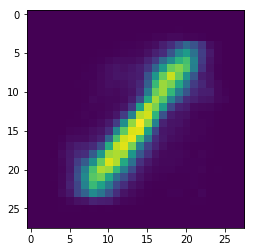

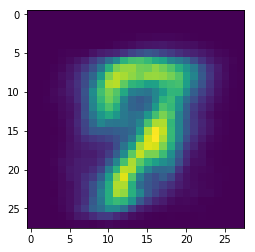

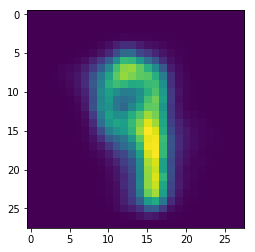

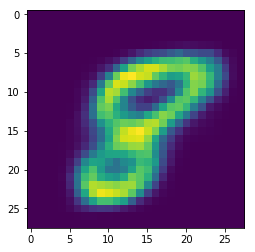

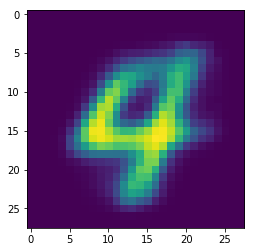

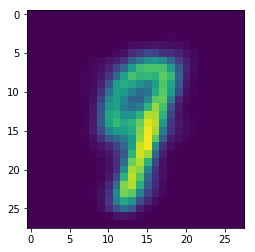

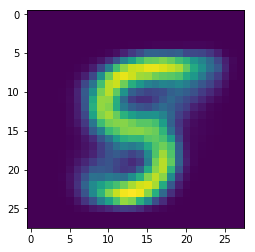

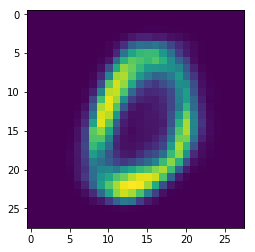

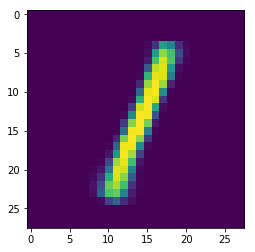

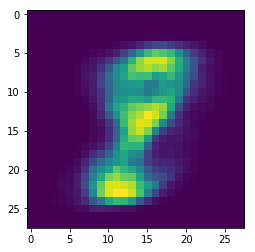

In [44]:
for i in range(10):
    h = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
    for d in H.downwards:
        h = hard_sample_binary_concrete(d(h))
    recovery = D(h).view(28,28).data.cpu().numpy()
    plt.imshow(recovery)
    plt.show()

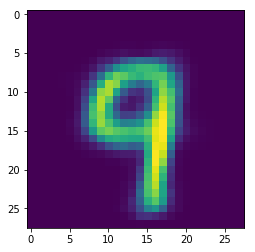

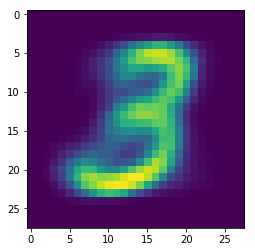

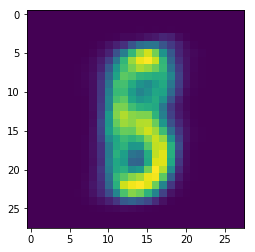

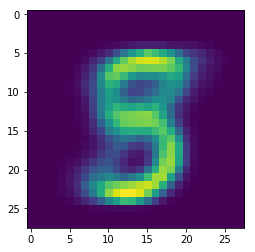

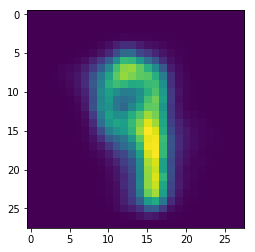

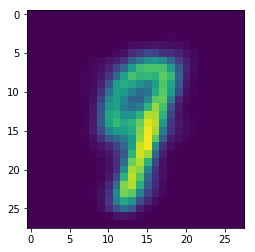

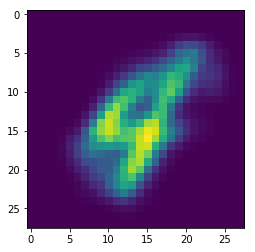

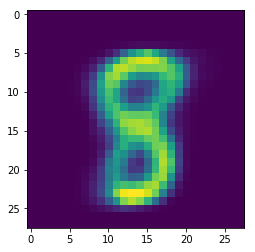

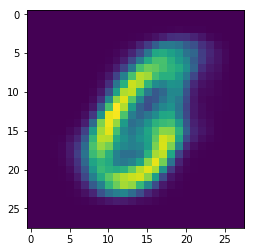

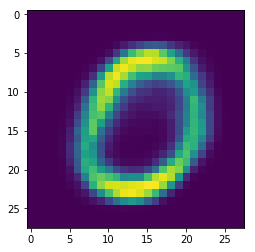

In [52]:
fixed = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
for i in range(10):
    h = fixed
    for d in H.downwards:
        h = hard_sample_binary_concrete(d(h))
    recovery = D(h).view(28,28).data.cpu().numpy()
    plt.imshow(recovery)
    plt.show()

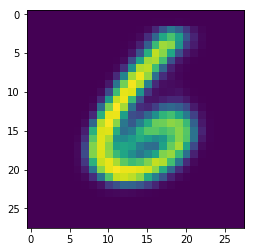

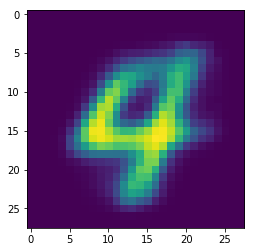

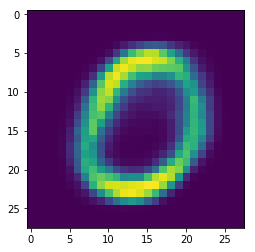

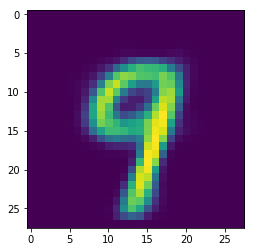

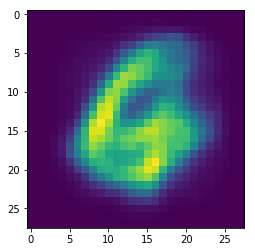

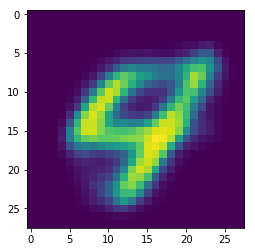

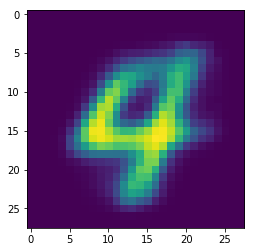

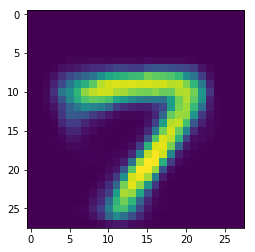

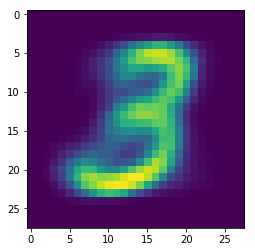

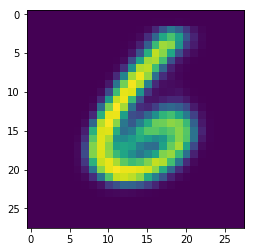

In [67]:
fixed = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
for d in list(H.downwards)[:2]:
    fixed = hard_sample_binary_concrete(d(fixed))
for i in range(10):
    h = fixed
    for d in list(H.downwards)[2:]:
        h = hard_sample_binary_concrete(d(h))
    recovery = D(h).view(28,28).data.cpu().numpy()
    plt.imshow(recovery)
    plt.show()

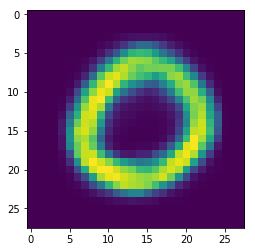

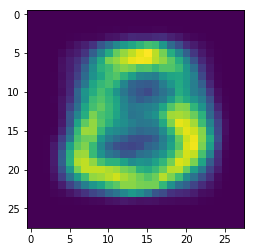

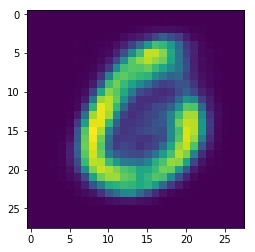

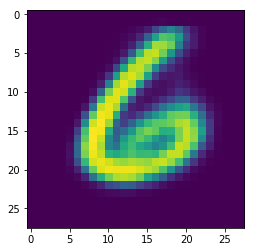

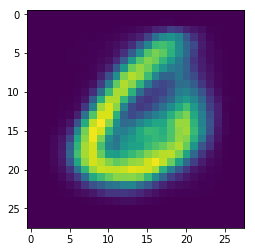

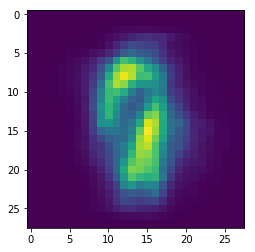

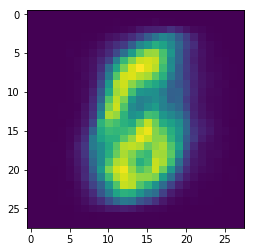

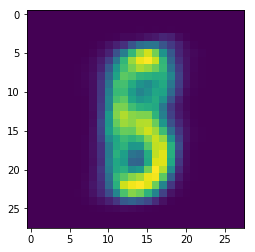

In [108]:
a = torch.FloatTensor((0,0,0,0,0,0,0,0))
for i in range(8):
    a[i] = 1.
    t = Variable(a).unsqueeze(0)
    recovery = D(t).view(28,28).data.cpu().numpy()
    plt.imshow(recovery)
    plt.show()

In [104]:
[0]=0